In [80]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities

import time
import json
import requests

from key import BASE_URL


In [81]:
index_codes = ['VIX', 'INDEXNASDAQ: .IXIC', 'INDEXSP: .INX', 'INDEXDJX: .DJI']
index_names = ['vix', 'NASDAQ', 'SP_500', 'NY_Dow']

i = 0
values_array = []

In [82]:
def remove_before_bracket_and_after_newline(s):
    # '['前の文字を削除
    bracket_index = s.find('[')
    if bracket_index != -1:
        s = s[bracket_index:]

    # 改行以降の文字を削除
    newline_index = s.find('\n')
    if newline_index != -1:
        s = s[:newline_index]

    return s

In [83]:
def parse_array_string(array_string):
    def parse_helper(s):
        # 空白文字を除去
        s = s.strip()
        if s.startswith('[') and s.endswith(']'):
            s = s[1:-1]
        else:
            return s.strip()  # Base case: return the stripped string itself

        result = []
        nested_level = 0
        start_index = 0

        for i, char in enumerate(s):
            if char == '[':
                if nested_level == 0:
                    start_index = i
                nested_level += 1
            elif char == ']':
                nested_level -= 1
                if nested_level == 0:
                    result.append(parse_helper(s[start_index:i+1]))
            elif char == ',' and nested_level == 0:
                result.append(parse_helper(s[start_index:i]))
                start_index = i + 1

        if start_index < len(s):
            result.append(parse_helper(s[start_index:]))

        return result

    return parse_helper(array_string)

In [84]:
def index_values(index):
    res_text = remove_before_bracket_and_after_newline(index)

    parsed_array = parse_array_string(res_text)

    return parsed_array[0][2][0][0][4][0][2]

In [85]:
def test_get_days(stock_code):
    url = f"{BASE_URL}/getdays/{stock_code}"
    response = requests.get(url)
    print(f"GET /getdays/{stock_code} Response: {response.status_code} {response.text}")
    days = response.json()
    dates = list(set(entry['date'] for entry in days))
    print(len(days))
    print(len(dates))
    return dates


In [86]:
def index_for(index, name):
    pre_date = ''
    # JSONデータをforループで回す
    for sp in reversed(index):

        date = f'{sp[0][0]}-{sp[0][1]}-{sp[0][2]}'
        update_value = str(sp[2][0])

        if date != pre_date:
            print(f"Date: {date}, Close: {update_value}")
            data = {
                "date": date,
                "column_name": name,
                "update_value": update_value,
            }

            print("Data to be sent in POST request:", data)

            response = requests.post(f"{BASE_URL}/update_column", json=data)
            print(f"POST /update_column Response: {response.status_code} {response.text}")

            pre_date = date
            if date == '2024-4-1':
                break


In [87]:
for index_code in index_codes:

    caps = DesiredCapabilities.CHROME
    caps['goog:loggingPrefs'] = {'performance': 'ALL'}

    options = Options()

    options.add_experimental_option("detach", True)

    options.add_argument("--no-sandbox")

    options.add_argument("--headless")

    options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36")

    driver = webdriver.Chrome(options=options)

    url = 'https://www.google.com/finance/?hl=ja'
    driver.get(url)

    time.sleep(1)

    stock_code_input = driver.find_element(By.XPATH, r'/html/body/c-wiz[2]/div/div[3]/div[3]/div/div/div/div[1]/input[2]')
    stock_code_input.send_keys(index_code)
    stock_code_input.send_keys(Keys.RETURN)

    time.sleep(3)

    current_url = driver.current_url
    new_url = f"{current_url}&window=6M"
    driver.get(new_url)
    logs = driver.get_log('performance')

    batch_request_urls = []
    headers = {}
    post_data = None

    if index_code == 'INDEXNASDAQ: .IXIC':
        index_code = '.IXIC%3AINDEXNASDAQ'
    if index_code == 'INDEXSP: .INX':
        index_code = '.INX%3AINDEXSP'
    if index_code == 'INDEXDJX: .DJI':
        index_code = '.DJI%3A'


    for entry in logs:
        log = json.loads(entry['message'])['message']
        try:
            if 'Network.requestWillBeSent' in log['method']:
                request_url = log['params']['request']['url']
                # print(request_url)
                if f'https://www.google.com/finance/_/GoogleFinanceUi/data/batchexecute?rpcids=AiCwsd&source-path=%2Ffinance%2Fquote%2F{index_code}' in request_url:
                    batch_request_urls.append(request_url)
                    headers = log['params']['request']['headers']
                    if 'postData' in log['params']['request']:
                        post_data = log['params']['request']['postData']
        except KeyError:
            continue

    print(batch_request_urls)
    if index_code == '.IXIC:INDEXNASDAQ':
        index_code = r'.IXIC\",\"INDEXNASDAQ'

    if index_code == 'INDEXSP: .INX':
        index_code = r'.INX\",\"INDEXSP'

    if index_code == '.DJI%3AINDEXDJX':
        index_code = r'.DJI\",\"INDEXDJX'

    target_string = fr'[["wrb.fr","AiCwsd","[[[[\"{index_code}\",'

    print(type(batch_request_urls))

    response = requests.post(batch_request_urls[0], headers=headers, data=post_data)
    # print(response.text)

    values_array.append(index_values(response.text))

    driver.close()



# for index_name, index_value in zip(index_names, values_array):
#     index_for(index_value, index_name)

['https://www.google.com/finance/_/GoogleFinanceUi/data/batchexecute?rpcids=AiCwsd&source-path=%2Ffinance%2Fquote%2FVIX%3AINDEXCBOE&f.sid=6900462642377087170&bl=boq_finance-ui_20240723.00_p0&hl=ja&soc-app=162&soc-platform=1&soc-device=1&_reqid=12108&rt=c', 'https://www.google.com/finance/_/GoogleFinanceUi/data/batchexecute?rpcids=AiCwsd&source-path=%2Ffinance%2Fquote%2FVIX%3AINDEXCBOE&f.sid=6900462642377087170&bl=boq_finance-ui_20240723.00_p0&hl=ja&soc-app=162&soc-platform=1&soc-device=1&_reqid=112108&rt=c']
<class 'list'>
['https://www.google.com/finance/_/GoogleFinanceUi/data/batchexecute?rpcids=AiCwsd&source-path=%2Ffinance%2Fquote%2F.IXIC%3AINDEXNASDAQ&f.sid=2014335434714846475&bl=boq_finance-ui_20240723.00_p0&hl=ja&soc-app=162&soc-platform=1&soc-device=1&_reqid=12124&rt=c', 'https://www.google.com/finance/_/GoogleFinanceUi/data/batchexecute?rpcids=AiCwsd&source-path=%2Ffinance%2Fquote%2F.IXIC%3AINDEXNASDAQ&f.sid=2014335434714846475&bl=boq_finance-ui_20240723.00_p0&hl=ja&soc-app=16

In [88]:
data_array = []
for array in values_array:
    # print(array)
    pre_array = []
    for sp in array:
        date = f'{sp[0][0]}-{sp[0][1]}-{sp[0][2]}'
        update_value = str(sp[2][0])

        # print(date)
        data = [date, update_value]

        pre_array.append(data)
    data_array.append(pre_array)
print(data_array)

[[['2024-2-26', '5069.53'], ['2024-2-26', '5069.53'], ['2024-2-27', '5078.18'], ['2024-2-27', '5078.18'], ['2024-2-28', '5069.76'], ['2024-2-28', '5069.76'], ['2024-2-29', '5096.27'], ['2024-2-29', '5096.27'], ['2024-3-1', '5137.08'], ['2024-3-1', '5137.08'], ['2024-3-4', '5130.95'], ['2024-3-4', '5130.95'], ['2024-3-5', '5078.65'], ['2024-3-5', '5078.65'], ['2024-3-6', '5104.76'], ['2024-3-6', '5104.76'], ['2024-3-7', '5157.36'], ['2024-3-7', '5157.36'], ['2024-3-8', '5123.69'], ['2024-3-8', '5123.69'], ['2024-3-11', '5117.94'], ['2024-3-11', '5117.94'], ['2024-3-12', '5175.27'], ['2024-3-12', '5175.27'], ['2024-3-13', '5165.31'], ['2024-3-13', '5165.31'], ['2024-3-14', '5150.48'], ['2024-3-14', '5150.48'], ['2024-3-15', '5117.09'], ['2024-3-15', '5117.09'], ['2024-3-18', '5149.42'], ['2024-3-18', '5149.42'], ['2024-3-19', '5178.51'], ['2024-3-19', '5178.51'], ['2024-3-20', '5224.62'], ['2024-3-20', '5224.62'], ['2024-3-21', '5241.53'], ['2024-3-21', '5241.53'], ['2024-3-22', '5234.18

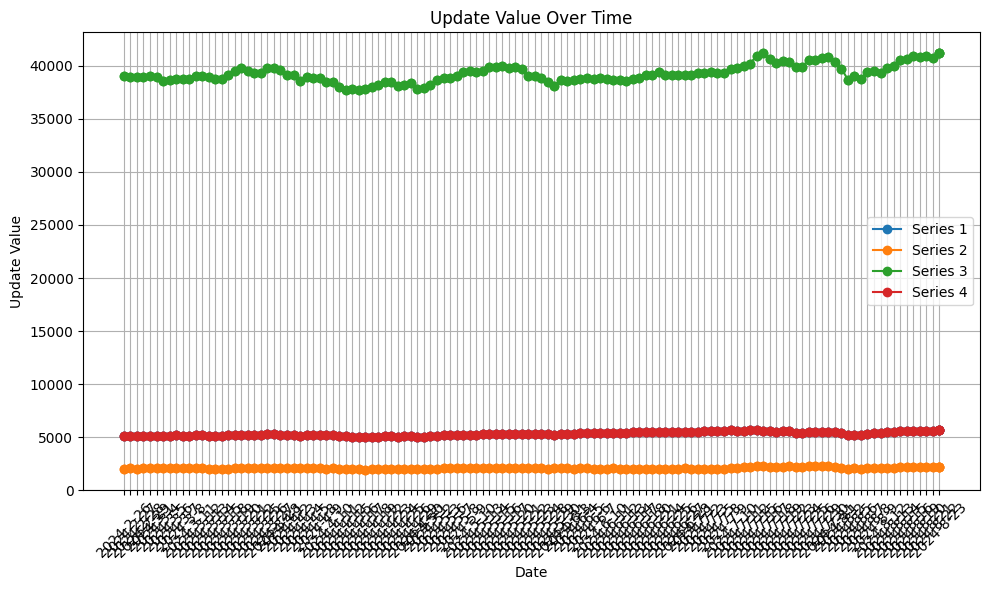

In [89]:
import matplotlib.pyplot as plt

# グラフの作成
plt.figure(figsize=(10, 6))

for idx, array in enumerate(data_array):
    dates = [data[0] for data in array]
    update_values = [float(data[1]) for data in array]

    plt.plot(dates, update_values, marker='o', label=f'Series {idx + 1}')

plt.xlabel('Date')
plt.ylabel('Update Value')
plt.title('Update Value Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# グラフの表示
plt.show()